In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carrega a tabela imortação
imp_fert=pd.read_csv('~/git/BD/temp/imp_fert1.csv')

# Carrega a tabela com características adicionais de cada NCM
ncm_e=pd.read_csv('~/git/BD/Comexstat/tab_complementares/ncm_e.csv')

# Insere a data
imp_fert.insert(0,'date',pd.to_datetime(imp_fert.CO_ANO.astype(str)+'/'+imp_fert.CO_MES.astype(str)+'/1'))

# Funde as tabelas
imp_fert=ncm_e.merge(imp_fert)

# Ranqueia a seleciona os 10 maiores NCMs em peso
imp_fert_top=imp_fert.groupby('CO_NCM').KG_LIQUIDO.sum().sort_values(ascending=False).reset_index().head(10)['CO_NCM'].values

# Filtra a tabela deixano passar somente os registros dos NCMs top
imp_fert=imp_fert[imp_fert.CO_NCM.isin(imp_fert_top)]

imp_fert=imp_fert[(imp_fert.KG_LIQUIDO>0)&(imp_fert.VL_FOB>0)]

In [2]:
# Corrige erro do tipo aleatório que visualmente comprime os pesos na parte baixa do gráfico da ureia, sendo esse o único valor
# de potência 10**9 de todo o conjunto de dados.

# Cria tabela temporária somente com o registro do erro máximo
imp_fert_err=imp_fert[imp_fert.KG_LIQUIDO==imp_fert.KG_LIQUIDO.max()]

# Cria tabela temporária sem o erro registro do erro máximo
imp_fert_correto=imp_fert[imp_fert.KG_LIQUIDO!=imp_fert.KG_LIQUIDO.max()]

# Identifica data e NCM do erro
data_prdt_err=imp_fert_err[['date','CO_NCM']]

# Identifica registros sem erro na mesma data com o mesmo produto
imp_fert_correto_data_err=imp_fert_correto.merge(data_prdt_err)

# Calcula soma do valores e pesos corretos na data e para o produto do erro
imp_fert_correto_data_err=imp_fert_correto_data_err.groupby('CO_NCM')[['VL_FOB','KG_LIQUIDO']].sum()

# Cálcula o preço médio correto do produto na data do erro
preço_correção=(imp_fert_correto_data_err.VL_FOB / imp_fert_correto_data_err.KG_LIQUIDO).values[0]

# Cálcula o preço correto do produto na data do erro, e o insere na tabela com erro
#imp_fert_correto_data_err=imp_fert_correto_data_err.assign(preço=preço_correção)
#preço_correção=imp_fert_correto_data_err.preço.values[0]

# Através do valor importado, que já estava correto, e do preço corrigido, se determina o peso corrigido
imp_fert_err.loc[:,'KG_LIQUIDO']=round(imp_fert_err.VL_FOB / preço_correção)#.astype(int)

# Conclui a correção
imp_fert_corrigido=imp_fert_err

# Concatena importações corrigidas e originalmente corretas
imp_fert=pd.concat([imp_fert_corrigido,imp_fert_correto])

In [3]:
# Importa função que corrige inflação
%run 'corrige_inflação_dólar.ipynb'


Função ***corrige_inflação_dólar(df_ano_mes_valor,col_vl_name)*** disponível.



In [4]:
# Corrige a inflação sobre os valores
for col in ['VL_FOB','VL_FRETE','VL_SEGURO']:
    imp_fert=corrige_inflação_dólar(imp_fert,col)

In [5]:
# Filtra deixando passar somente  a via 1
imp_fert=imp_fert[imp_fert.CO_VIA==1]

# Descarta as colunas como previsto
imp_fert.drop(columns=['CO_VIA','CO_UNID','QT_ESTAT'],inplace=True)

# Clusteriza

In [6]:
### Clusterização pelo preço

# Cria coluna 'preço'
imp_fert=imp_fert.assign(preço=(imp_fert.VL_FOB+imp_fert.VL_FRETE+imp_fert.VL_SEGURO)/imp_fert.KG_LIQUIDO)

%run 'norm_20_bins.ipynb'


Função norm_20_bins() disponível.



In [7]:
col_target='preço'

# Clusteriza pelo preço
#r=pd.DataFrame()
ncm=31042090
imp_fert_t=imp_fert[imp_fert.CO_NCM==ncm].reset_index(drop=True)

q=pd.DataFrame()
r=pd.DataFrame()
for n in range(1,29):
    
    # Inicia o algorítmo de clusterização
    from sklearn.cluster import KMeans as KM
    KM=KM(n_clusters=n, n_init='auto', random_state=1)

    # Clusteriza
    imp_fert_t2_km=imp_fert_t.assign(km=KM.fit_predict(imp_fert_t[['preço']])).assign(n_cluster=n)

    # Concatena resultado dos testes I
    r=pd.concat([r,imp_fert_t2_km])

    # Identifica cluster de interesse
    km_top=imp_fert_t2_km.groupby('km').KG_LIQUIDO.count().sort_values(ascending=False).reset_index().head(1)['km'][0]

    # Filtra deixando passar somente cluester de interesse
    imp_fert_t2_km_top=imp_fert_t2_km[imp_fert_t2_km.km==km_top]

    # Identifica coluna a ser avaliada quanto a normalidade
    ps=imp_fert_t2_km_top[col_target]

    # Avalia a normalidade
    normalidade=norm_20_bins(ps)

    # Cria tabela com as características e os resultados dos testes
    imp_fert_t2_km_top_res=imp_fert_t2_km_top[['CO_NCM']].drop_duplicates()\
    .assign(norm=normalidade).assign(n_cluster=n).assign(count_perct=len(imp_fert_t2_km_top)/len(imp_fert_t2_km))\
    .assign(kg_perct=imp_fert_t2_km_top.KG_LIQUIDO.sum()/imp_fert_t2_km.KG_LIQUIDO.sum())

    # Concatena os resultados dos testes II
    q=pd.concat([q,imp_fert_t2_km_top_res])

q=q.assign(norm_diff=q.diff().norm)

In [8]:
n_cluster_escolhido=q[q.norm_diff==q.norm_diff.max()].n_cluster.values[0]-1

In [9]:
q_1=q[q.n_cluster==n_cluster_escolhido].merge(r)

In [10]:
list_km_top=q_1.groupby('km').KG_LIQUIDO.count().sort_values(ascending=False).reset_index()[['km']].values.flat[:]

In [11]:
q_2=q_1[q_1.km.isin(list_km_top)]

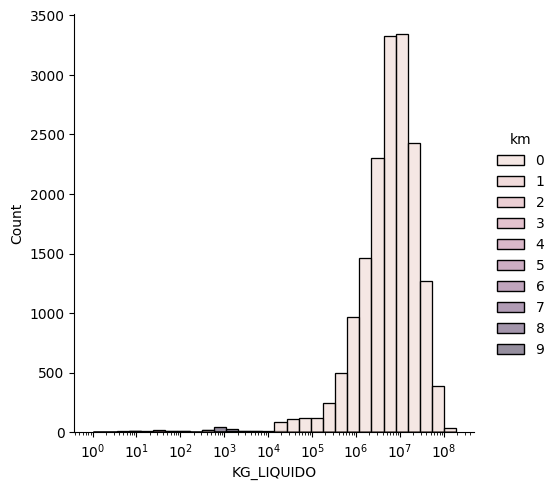

In [12]:
sns.displot(data=q_2[['KG_LIQUIDO','km']],x='KG_LIQUIDO',hue='km',log_scale=True,bins=30)
plt.show()

In [13]:
q_2=q_2.assign(date=pd.to_datetime(q_2.CO_ANO.astype(str)+'/'+q_2.CO_MES.astype(str)+'/1').astype(int))

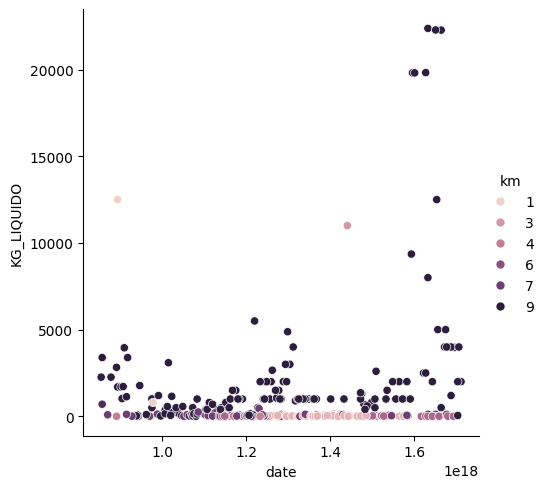

In [14]:
sns.relplot(data=q_2[q_2.km!=0],y='KG_LIQUIDO',x='date',hue='km')

In [15]:
a=

SyntaxError: invalid syntax (62411553.py, line 1)

In [ ]:
q_l=pd.concat([q.assign(tipo='limpo'),imp_fert_t.assign(tipo='orig')])

In [ ]:
sns.displot(data=q_l,x='KG_LIQUIDO',log_scale=True,bins=30,height=2,aspect=3*1.6, hue='tipo')

In [ ]:
sns.displot(data=q,x='KG_LIQUIDO',log_scale=True,bins=30,height=2,aspect=3*1.6)

In [ ]:
q.KG_LIQUIDO.max()/10**8

In [ ]:
q[['CO_ANO','CO_MES','norm','count','kg_perc','km','norm_diff']]

In [ ]:
r

In [ ]:
a=

In [ ]:
#r=pd.concat([r,q])

q[['CO_NCM','n_cluster','norm']]

In [ ]:
a=

In [ ]:
km_sel=pd.DataFrame({'name':['NP','MAP','NPK','Outros cloretos de potássio','Outros superfosfatos','NAM','SAM','ureia'],
             'n':[6,22,22,26,6,18,26,18]})

In [ ]:
imp_fert_km_sel=imp_fert_km.merge(km_sel)

In [ ]:
rank_correto=imp_fert_km_sel.groupby(by=['name','km']).KG_LIQUIDO.sum().reset_index().sort_values(by=['name','KG_LIQUIDO'],ascending=False)
rank_correto=rank_correto.groupby(by=['name']).KG_LIQUIDO.max().reset_index().merge(rank_correto)

In [ ]:
imp_fert_km_sel_correto=imp_fert_km_sel.merge(rank_correto[['name','km']])

In [ ]:
imp_fert_km_sel_erro=imp_fert_km_sel[~imp_fert_km_sel.index.isin(imp_fert_km_sel_correto.index)]

In [ ]:
len(imp_fert_km_sel_erro)/len(imp_fert_km_sel_correto)*100

In [ ]:
imp_fert_km_sel_erro.KG_LIQUIDO.sum()/imp_fert_km_sel_correto.KG_LIQUIDO.sum()*100

In [ ]:
imp_fert_km_sel_erro.VL_FOB.sum()/imp_fert_km_sel_correto.VL_FOB.sum()*100

In [ ]:
imp_fert_km_sel_erro=imp_fert_km_sel_erro.assign(erro_kg=0)
imp_fert_km_sel_erro.loc[imp_fert_km_sel_erro.KG_LIQUIDO<10**3.1,'erro_kg']=1

In [ ]:
imp_fert_km_sel_erro=imp_fert_km_sel_erro.assign(erro_vl=0)
imp_fert_km_sel_erro.loc[imp_fert_km_sel_erro.VL_FOB<10**3.2,'erro_vl']=1

In [ ]:
imp_fert_km_sel_erro=imp_fert_km_sel_erro.assign(descarte=0)
imp_fert_km_sel_erro.loc[(imp_fert_km_sel_erro.erro_kg==1)&(imp_fert_km_sel_erro.erro_vl==1),'descarte']=1

In [ ]:
imp_fert_km_sel_erro_limpo=imp_fert_km_sel_erro[imp_fert_km_sel_erro.descarte==0].drop(columns='descarte')

In [ ]:
len(imp_fert_km_sel_erro_limpo)/len(imp_fert_km_sel)*100

In [ ]:
imp_fert_km_sel_erro_limpo.KG_LIQUIDO.sum()/imp_fert_km_sel.KG_LIQUIDO.sum()*100

In [ ]:
imp_fert_km_sel_erro_limpo.VL_FOB.sum()/imp_fert_km_sel.VL_FOB.sum()*100

In [ ]:
len(imp_fert_km_sel_correto)/len(imp_fert_km_sel)*100

In [ ]:
imp_fert_km_sel_correto.KG_LIQUIDO.sum()/imp_fert_km_sel.KG_LIQUIDO.sum()*100

In [ ]:
imp_fert_km_sel_correto.VL_FOB.sum()/imp_fert_km_sel.VL_FOB.sum()*100

In [ ]:
i_f_km_s_c=imp_fert_km_sel_correto

In [ ]:
# Determina características dos clusters para identificação deles posteriormente
q=pd.DataFrame()
for ncm in i_f_km_s_c.CO_NCM.unique():
    i_f_km_s_c_t=i_f_km_s_c[i_f_km_s_c.CO_NCM==ncm]
    i_f_km_s_c_t=i_f_km_s_c_t.assign(média=i_f_km_s_c_t.KG_LIQUIDO.mean())
    i_f_km_s_c_t=i_f_km_s_c_t.assign(std=i_f_km_s_c_t.KG_LIQUIDO.std())
    q=pd.concat([q,i_f_km_s_c_t])
i_f_km_s_c=q

In [ ]:
m_s=i_f_km_s_c[['name','média','std']].drop_duplicates()

ncm_e=ncm_e.merge(m_s,how='left')

# Salva nova tabela de ncm expandida
ncm_e.to_csv('~/git/BD/Comexstat/tab_complementares/ncm_e.csv',index=False)

In [ ]:
i_f_km_s_c.to_csv('~/git/BD/temp/imp_fert2.csv',index=False)

In [ ]:
sns.displot(data=imp_fert_km_sel_correto,x='KG_LIQUIDO',log_scale=True,col='name', bins=20, facet_kws=dict(sharex=False, sharey=False))
plt.show()

In [ ]:
sns.displot(data=imp_fert_km_sel_correto,x='VL_FOB',log_scale=True,col='name', bins=20, facet_kws=dict(sharex=False, sharey=False))
plt.show()